In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import quandl
import datetime
import statsmodels.api as sm
from tensorflow.keras.callbacks import Callback

In [2]:
start = datetime.datetime(2006,1,1)
end = datetime.date.today()
quandl.ApiConfig.api_key = "1sW4FWcqKdfzHmMzKnPr"
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)
amz.shape

(3077, 12)

In [3]:
def plot_prediction(test, prediction, pos=0):
    plt.plot(test[pos:], label='Real Price')
    plt.plot(prediction, label='Predicted Price')
    plt.title('Amazon Stocks')
    plt.xlabel('days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
def return_rmse(test, prediction):
    rmse = math.sqrt(mean_squared_error(test, prediction))
    print('The RMSE is {}'.format(rmse))
    
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.plot(hist['epoch'], hist['mse'], label='train mse')
    plt.plot(hist['epoch'], hist['val_mse'], label='val mse')
#     plt.ylim([0.5, 0.7])
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('mae [%]')
    plt.plot(hist['epoch'], hist['mae']*100., label='train mae')
    plt.plot(hist['epoch'], hist['val_mae']*100., label='val mae')
#     plt.ylim([90, 100])
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('Forecasting Mean Absolute Error: {:4.2f}%'.format(np.min(hist['mae'].values)*100))
    
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 5 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=5, factor=100.):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None
        self.factor = factor

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/self.factor
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, lost patience and terminating training' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print(' baseline increased since learning is losing patience')

In [4]:
year0 = '2016'
year1 = '2017'
# dataset = amz[:year1].iloc[:,:5]
dataset = amz.iloc[:,:5]
training_data = dataset[:year0].iloc[:,1:2].values
test_data = dataset[year1:].iloc[:,1:2].values

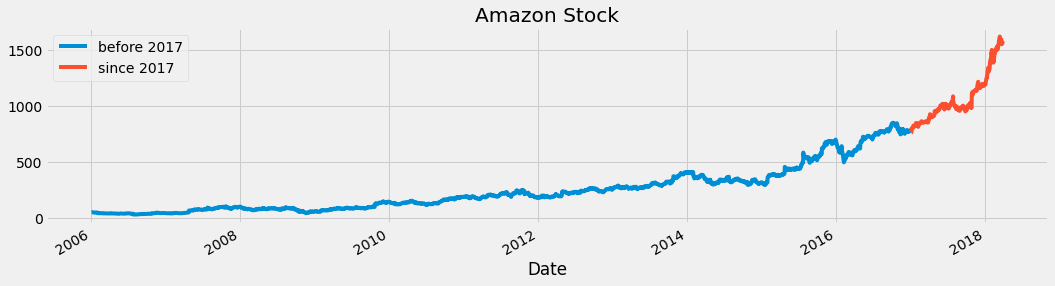

In [5]:
dataset['High'][:year0].plot(figsize=(16,4), legend=True)
dataset['High'][year1:].plot(figsize=(16,4), legend=True)
plt.legend(['before '+year1, 'since '+year1])
plt.title('Amazon Stock')
plt.show()

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
training_data_scaled = sc.fit_transform(training_data)

In [7]:
X_train = []
Y_train = []
length = 60
for i in range(length, training_data.shape[0]):
    X_train.append(training_data_scaled[i-length:i, 0])
    Y_train.append(training_data_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

# LSTM Analysis

In [16]:
time_machine = Sequential()
time_machine.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
time_machine.add(Dropout(0.2))
time_machine.add(LSTM(units=128))
time_machine.add(Dropout(0.2))
time_machine.add(Dense(units=1))
time_machine.summary()

time_machine.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])

history = time_machine.fit(X_train, Y_train,
                           epochs=300, batch_size=32, validation_split=0.1, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=5), PrintDots()])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.012948845513164997
***** epochs =  5  val_loss =  0.0018257249612361193
***** epochs =

In [17]:
dataset_total = pd.concat((dataset['High'][:year0], dataset['High'][year1:]), axis=0)
inputs = dataset_total[dataset_total.shape[0] - test_data.shape[0] - length:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

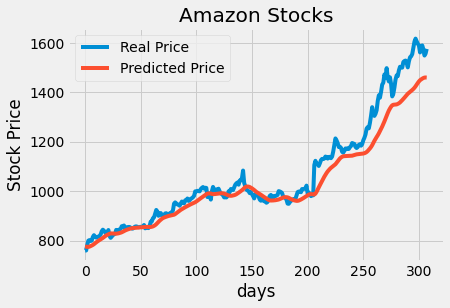

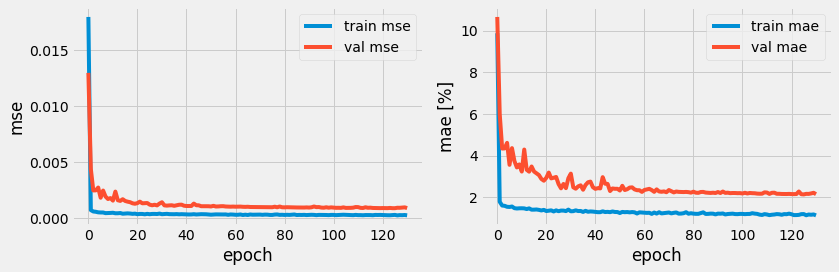

Forecasting Mean Absolute Error: 1.14%


In [18]:
X_test = []
for i in range(length, inputs.shape[0]):
    X_test.append(inputs[i-length:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_prices = time_machine.predict(X_test)
predicted_prices = sc.inverse_transform(predicted_prices)
plot_prediction(test_data, predicted_prices)
plot_history(history)

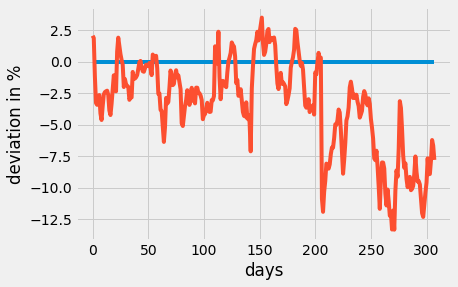

In [29]:
dev = ((predicted_prices.T-test_data.T)/test_data.T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.show()

In [30]:
x = predicted_prices
y = test_data
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.313e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):          2.18e-253
Time:                        00:54:26   Log-Likelihood:                -1510.3
No. Observations:                 308   AIC:                             3025.
Df Residuals:                     306   BIC:                             3032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -197.3986     11.167    -17.677      0.0

# GRU analysis

In [31]:
time_machine_GRU = Sequential()
time_machine_GRU.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
time_machine_GRU.add(Dropout(0.2))
time_machine_GRU.add(GRU(units=128, activation='tanh'))
time_machine_GRU.add(Dropout(0.2))
time_machine_GRU.add(Dense(units=1))
time_machine_GRU.summary()

time_machine_GRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])
history = time_machine_GRU.fit(X_train, Y_train,
                               epochs=300, batch_size=32, validation_split=0.05, verbose=0,
                               callbacks=[TerminateOnBaseline(monitor='val_loss', patience=5), PrintDots()])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 60, 128)           50304     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 149,505
Trainable params: 149,505
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.00033898124820552766
***** epochs =  5  val_loss =  0.00026271326350979507
* baseline 

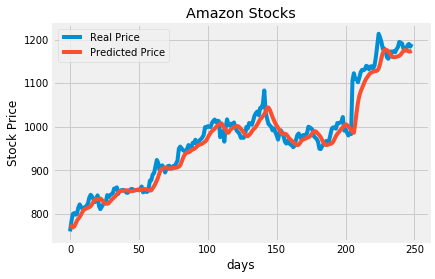

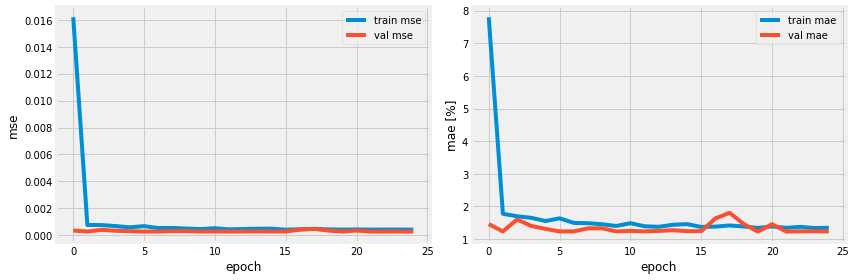

Forecasting Mean Absolute Error: 1.34%


In [32]:
predicted_prices_GRU = time_machine_GRU.predict(X_test)
predicted_prices_GRU = sc.inverse_transform(predicted_prices_GRU)
plot_prediction(test_data[:250], predicted_prices_GRU[:250])
plot_history(history)

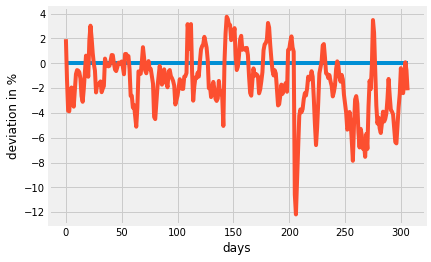

In [33]:
dev = ((predicted_prices_GRU[:-1].T-test_data[1:].T)/test_data[1:].T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.show()

In [34]:
x = predicted_prices_GRU[:-1]
y = test_data[1:]
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.990e+04
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          8.52e-280
Time:                        22:02:06   Log-Likelihood:                -1441.7
No. Observations:                 307   AIC:                             2887.
Df Residuals:                     305   BIC:                             2895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.0469      8.107     -7.160      0.0

# Bidirectional GRU

In [13]:
time_machine_GRU_BD = Sequential()
time_machine_GRU_BD.add(Bidirectional(GRU(units=128, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
time_machine_GRU_BD.add(Dropout(0.2))
time_machine_GRU_BD.add(Dense(units=1))
time_machine_GRU_BD.summary()

time_machine_GRU_BD.compile(optimizer=SGD(lr=0.01, decay=1e-8, momentum=0.9, nesterov=False),
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])
history = time_machine_GRU_BD.fit(X_train, Y_train,
                               epochs=300, batch_size=32, validation_split=0.05, verbose=0,
                               callbacks=[TerminateOnBaseline(monitor='val_loss', patience=5), PrintDots()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               100608    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 100,865
Trainable params: 100,865
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.0019629274029284716
***** epochs =  5  val_loss =  0.0015922591555863619
** baseline increased since learning is losing patience
*** baseline increased since learning is losing patience
 epochs =  10  val_loss =  0.0011138460831716657
*** baseline increased since learning is losing patience
** epochs =  15  val_loss =  0.0008294675499200821
* basel

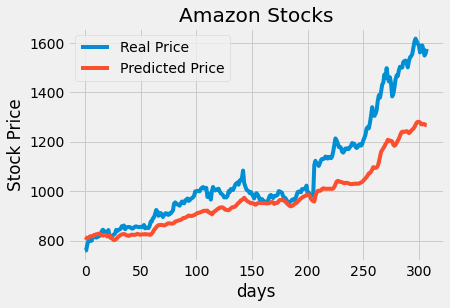

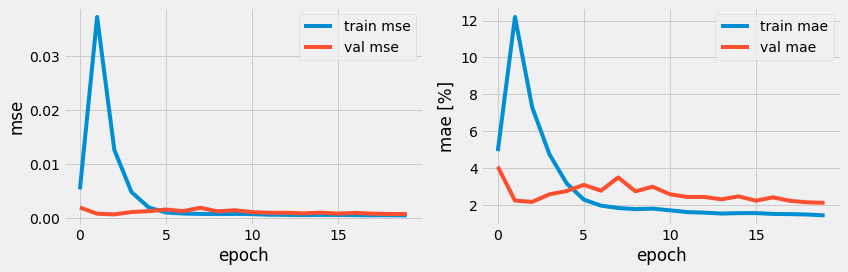

Forecasting Mean Absolute Error: 1.43%


In [14]:
predicted_prices_BD = time_machine_GRU_BD.predict(X_test)
predicted_prices_BD = sc.inverse_transform(predicted_prices_BD)
plot_prediction(test_data, predicted_prices_BD)
plot_history(history)

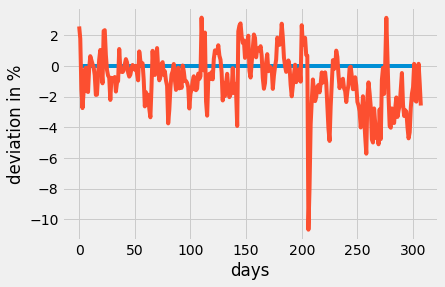

In [25]:
dev = ((predicted_prices_BD.T-test_data.T)/test_data.T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.show()

In [26]:
x = predicted_prices_BD
y = test_data
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.157e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        00:41:58   Log-Likelihood:                -1335.2
No. Observations:                 308   AIC:                             2674.
Df Residuals:                     306   BIC:                             2682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.6599      5.555     -8.579      0.0

# An attempt at 4 -> 1 anlysis using GRU

In [521]:
training_data_mv = dataset[:year0].iloc[:,0:4].values
test_data_mv = dataset[year1:].iloc[:,0:4].values
training_data_scaled_mv = sc.fit_transform(training_data_mv)

X_train_mv = []
Y_train_mv = []
for i in range(length, training_data_mv.shape[0]):
    X_train_mv.append(training_data_scaled_mv[i-length:i, :4])
    Y_train_mv.append(training_data_scaled_mv[i, 1])
X_train_mv, Y_train_mv = np.array(X_train_mv), np.array(Y_train_mv)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [524]:
time_machine_GRU = Sequential()
time_machine_GRU.add(GRU(units=128, return_sequences=True, input_shape=(X_train_mv.shape[1],X_train_mv.shape[2]), activation='tanh'))
time_machine_GRU.add(Dropout(0.2))
time_machine_GRU.add(GRU(units=128, activation='tanh'))
time_machine_GRU.add(Dropout(0.2))
time_machine_GRU.add(Dense(units=1))
time_machine_GRU.summary()

time_machine_GRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])
history = time_machine_GRU.fit(X_train_mv, Y_train_mv,
                           epochs=300, batch_size=32, validation_split=0.1, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=5), PrintDots()])

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_56 (GRU)                 (None, 60, 128)           51456     
_________________________________________________________________
dropout_135 (Dropout)        (None, 60, 128)           0         
_________________________________________________________________
gru_57 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dropout_136 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 129       
Total params: 150,657
Trainable params: 150,657
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.0003782789863180369
***** epochs =  5  val_loss =  0.00037700869143009186
** baseline

In [527]:
dataset_total_mv = pd.concat((dataset.iloc[:,0:4][:year0], dataset.iloc[:,0:4][year1:]), axis=0)
inputs_mv = dataset_total_mv[dataset_total_mv.shape[0] - test_data_mv.shape[0] - length:].values
# inputs_mv = inputs_mv.reshape(-1,1)
inputs_mv = sc.transform(inputs_mv)

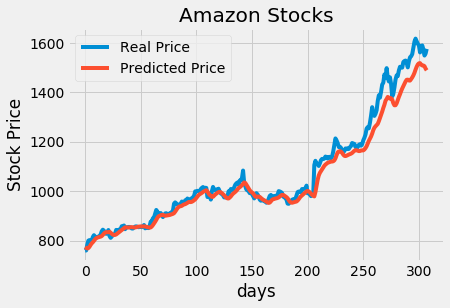

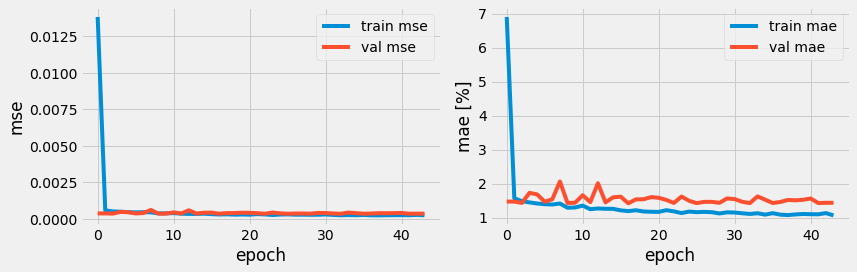

Forecasting Mean Absolute Error: 1.07%


In [546]:
X_test_mv = []
for i in range(length, inputs_mv.shape[0]):
    X_test_mv.append(inputs_mv[i-length:i, 0:4])
    
X_test_mv = np.array(X_test_mv)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_prices_mv = time_machine_GRU.predict(X_test_mv)
predicted_prices_mv = np.append(predicted_prices_mv, np.zeros((308,1)), axis=1)
predicted_prices_mv = np.append(predicted_prices_mv, np.zeros((308,1)), axis=1)
predicted_prices_mv = np.append(np.zeros((308,1)), predicted_prices_mv, axis=1)
predicted_prices_mv = sc.inverse_transform(predicted_prices_mv)[:, [1]]
plot_prediction(test_data_mv[:,1], predicted_prices_mv)
plot_history(history)

Text(0.5,0,'days')

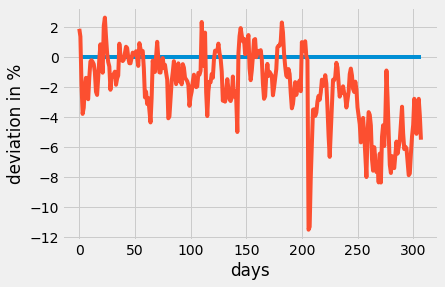

In [548]:
dev = ((predicted_prices_mv.T-test_data_mv[:,1].T)/test_data_mv[:,1].T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')

In [551]:
x = predicted_prices_mv
y = test_data_mv[:,1]
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.023e+04
Date:                Thu, 23 Jul 2020   Prob (F-statistic):          6.32e-308
Time:                        00:49:15   Log-Likelihood:                -1383.9
No. Observations:                 308   AIC:                             2772.
Df Residuals:                     306   BIC:                             2779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -115.6314      6.899    -16.762      0.0

# Multi-step analysis using GRU

In [45]:
X_train_multi = []
Y_train_multi = []
length = 120
future = 5 ## Keep even
for i in range(length, training_data.shape[0]-future):
    X_train_multi.append(training_data_scaled[i-length:i, 0])
    Y_train_multi.append(training_data_scaled[i:i+future, 0])
X_train_multi, Y_train_multi = np.array(X_train_multi), np.array(Y_train_multi)
X_train_multi = np.reshape(X_train_multi, (X_train_multi.shape[0], X_train_multi.shape[1],1))

In [80]:
time_machine_GRU_multi = Sequential()
time_machine_GRU_multi.add(GRU(units=196, return_sequences=True, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2]), activation='tanh'))
time_machine_GRU_multi.add(Dropout(0.2))
time_machine_GRU_multi.add(GRU(units=196, activation='tanh'))
time_machine_GRU_multi.add(Dropout(0.2))
time_machine_GRU_multi.add(Dense(units=future, activation='relu'))
time_machine_GRU_multi.summary()

time_machine_GRU_multi.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])
history = time_machine_GRU_multi.fit(X_train_multi, Y_train_multi,
                               epochs=300, batch_size=32, validation_split=0.05, verbose=0,
                               callbacks=[TerminateOnBaseline(monitor='val_loss', patience=5, factor=1000.), PrintDots()])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 120, 196)          117012    
_________________________________________________________________
dropout_18 (Dropout)         (None, 120, 196)          0         
_________________________________________________________________
gru_17 (GRU)                 (None, 196)               231672    
_________________________________________________________________
dropout_19 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 985       
Total params: 349,669
Trainable params: 349,669
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.1427956521511078
***** epochs =  5  val_loss =  0.0006436414550989866
***** epochs =  

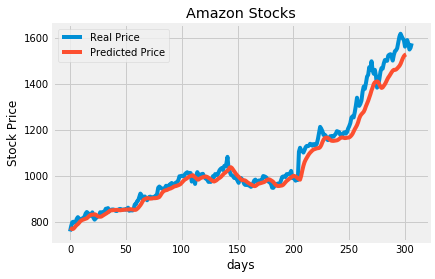

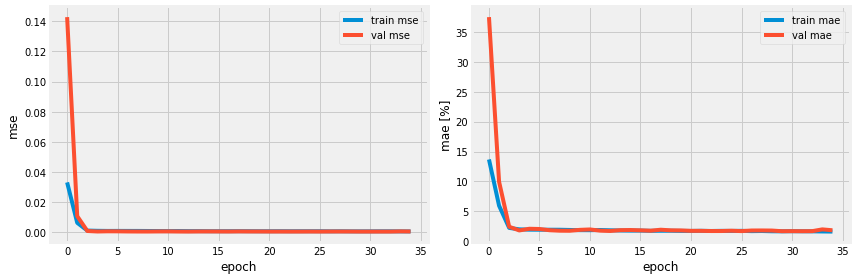

Forecasting Mean Absolute Error: 1.61%


In [82]:
dataset_total = pd.concat((dataset['High'][:year0], dataset['High'][year1:]), axis=0)
inputs = dataset_total[dataset_total.shape[0] - test_data.shape[0] - length:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test_multi = []
for i in range(length, inputs.shape[0]-future):
    X_test_multi.append(inputs[i-length:i, 0])
    
X_test_multi = np.array(X_test_multi)
X_test_multi = np.reshape(X_test_multi, (X_test_multi.shape[0], X_test_multi.shape[1],1))
predicted_prices_multi = time_machine_GRU_multi.predict(X_test_multi)
predicted_prices_multi = sc.inverse_transform(predicted_prices_multi)
plot_prediction(test_data, predicted_prices_multi[:,0], pos=0)
plot_history(history)

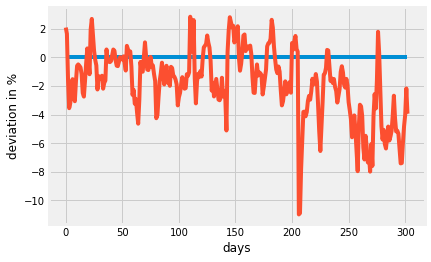

In [83]:
dev = ((predicted_prices_multi[:,0].T-test_data[:-future].T)/test_data[:-future].T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.show()

In [51]:
for i in range(0, future):
    x = predicted_prices_multi[:,i]
    y = test_data[i:i-future]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())
    print('==============================================================================')
    print('******************************************************************************')
    print('==============================================================================')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.262e+04
Date:                Thu, 23 Jul 2020   Prob (F-statistic):          3.02e-285
Time:                        21:39:39   Log-Likelihood:                -1390.5
No. Observations:                 303   AIC:                             2785.
Df Residuals:                     301   BIC:                             2793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -127.1600      7.986    -15.922      0.0